In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

In [2]:

from keras.preprocessing.text import one_hot,Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation,Dropout,Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split


In [3]:
import sys
import numpy
import tensorflow as tf

print("Python version:", sys.version)
print("NumPy version:", numpy.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)


Python version: 3.9.19 (main, May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)]
NumPy version: 1.23.5
TensorFlow version: 2.12.0
Keras version: 2.12.0


In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[]


In [5]:
import tensorflow as tf

# Check available devices
print("Available devices:", tf.config.list_physical_devices())

# Check GPU compatibility
gpu_devices = tf.config.list_physical_devices('GPU')
if not gpu_devices:
    print("No GPU detected. TensorFlow will run on CPU.")
else:
    print("GPUs detected:", gpu_devices)


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
No GPU detected. TensorFlow will run on CPU.


In [6]:
movie_reviews= pd.read_csv(r"C:\Users\user\OneDrive\Documents\GitHub\CODTECH-Task2\archive (4)\IMDB Dataset.csv")

In [7]:
movie_reviews.shape

(50000, 2)

In [8]:
movie_reviews.head(4)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative


In [9]:
movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

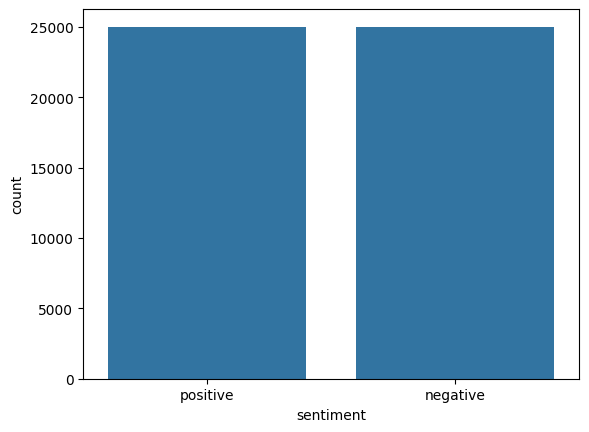

In [10]:
import seaborn as sns
sns.countplot(x='sentiment',data=movie_reviews)

In [11]:
movie_reviews["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [12]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
def preprocess_text(sen):
    sent = sen.lower()
    sent = remove_tags(sent)
    sent = re.sub('[^a-zA-Z]',' ',sent)
    sent = re.sub(r"\s+[a-zA-Z]\s+",' ',sent)
    sent = re.sub(r'\s+',' ', sent)
    
    pattern= re.compile(r'\b('+ r'|'.join(stopwords.words('english'))+r')\b\s*')
    sent = pattern.sub('', sent)
    
    return sent

In [15]:
X =[]
sentences= list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [16]:
X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [17]:
y= movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0,y)))

In [18]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)

In [19]:
word_tokenizer= Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [20]:
vocab_length = len(word_tokenizer.word_index)+1

vocab_length

92394

In [22]:
#padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen=100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [24]:
#GloVe

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt',encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

In [25]:
embeddings_matrix = zeros((vocab_length,100))
for word,index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector

In [26]:
embeddings_matrix.shape

(92394, 100)

In [27]:
#LSTM
from keras.layers import LSTM

model = Sequential()
embedding_layer = Embedding(vocab_length,100,weights=[embeddings_matrix],input_length=maxlen, trainable=False)

model.add(embedding_layer)

model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))


In [28]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9,356,777
Trainable params: 117,377
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [29]:
model_sid= model.fit(X_train, y_train,batch_size=128, epochs=6,verbose=1,validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 46s 179ms/step - loss: 0.4958 - acc: 0.7608 - val_loss: 0.5019 - val_acc: 0.7480
Epoch 2/6
250/250 [==============================] - 55s 219ms/step - loss: 0.4162 - acc: 0.8134 - val_loss: 0.4087 - val_acc: 0.8111
Epoch 3/6
250/250 [==============================] - 55s 221ms/step - loss: 0.3780 - acc: 0.8363 - val_loss: 0.3966 - val_acc: 0.8292
Epoch 4/6
250/250 [==============================] - 49s 196ms/step - loss: 0.3401 - acc: 0.8542 - val_loss: 0.3301 - val_acc: 0.8599
Epoch 5/6
250/250 [==============================] - 50s 202ms/step - loss: 0.3228 - acc: 0.8643 - val_loss: 0.3239 - val_acc: 0.8599
Epoch 6/6
250/250 [==============================] - 48s 190ms/step - loss: 0.3111 - acc: 0.8696 - val_loss: 0.3380 - val_acc: 0.8493


In [30]:
scores =model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 7s 22ms/step - loss: 0.3348 - acc: 0.8527


In [31]:
print("Test score:",scores[0])
print("Test accuracy:",scores[1])

Test score: 0.3347673714160919
Test accuracy: 0.8526999950408936


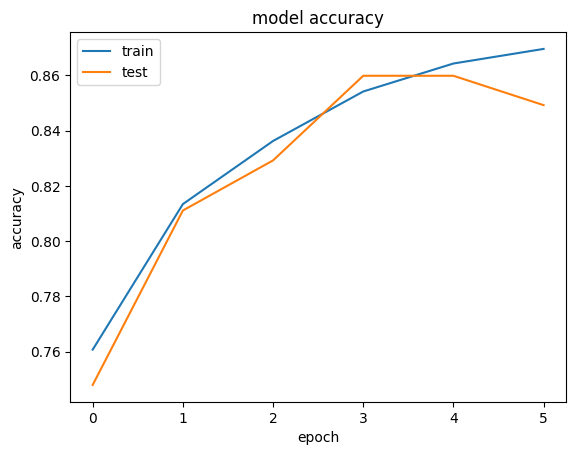

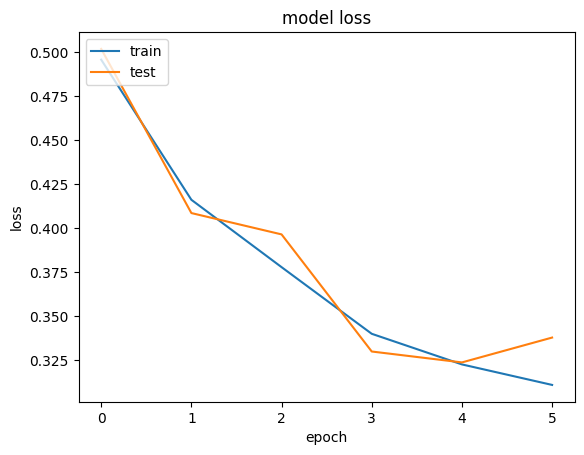

In [32]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(model_sid.history['acc'])
plt.plot(model_sid.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(model_sid.history['loss'])
plt.plot(model_sid.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [39]:
import h5py
print("h5py version:", h5py.__version__)
import tensorflow as tf
print("TensorFlow version:", tf.__version__)



h5py version: 3.12.1
TensorFlow version: 2.12.0


In [41]:
model.save(f"./sentiment_IMDb_model_acc_{round(scores[1], 3)}")


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x000001DE3E264E50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x000001DE3E264E50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get 

INFO:tensorflow:Assets written to: ./sentiment_IMDb_model_acc_0.853\assets


INFO:tensorflow:Assets written to: ./sentiment_IMDb_model_acc_0.853\assets


In [45]:
#Predictions

In [46]:
sample_reviews = pd.read_csv("sample_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [47]:
unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [48]:
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)


In [49]:
unseen_sentiments = model.predict(unseen_padded)

unseen_sentiments

Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x000001DE3E842700>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x000001DE3E842700>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x000001DE3E842700>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 345ms/step


array([[0.82028115],
       [0.9841643 ],
       [0.19204201],
       [0.41993943],
       [0.92842865],
       [0.02988436]], dtype=float32)

In [50]:
sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./sample_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.2
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.8
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,1.9
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,4.2
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.3
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.3
